# Обзор
Категоризация товаров это задача иерархической классификации. В ней информация для моделей обучения может поступать из двух мест: 1) признаки образцов 2) иерархия классов (граф), показывающая связь между группами образцов. Следовательно, модель мл для лучшего результата должна учитывать оба фактора. 

В качестве такой модели я выбрал алгоритм "local classifier per parent node" - который, начиная с корня графа, на каждую узловую ноду в графе категорий, строит по отдельному базовому классификатору, давая ему соответствующую этой ноде часть датасета. На этапе предикта, начиная с корня, идет по пути, который выбирают натренированные базовые классификаторы, до нижней узловой ноды, где уже определяет листовую категорию образца.

Другие варианты - локальный бинарный классификатор на каждую ноду, глобальный классификатор на все категории сразу -  пока отложил, потому что на мой взгляд они меньше учитывают иерархию, и более ресурсоемкие по времени.

Сначала потренируем алгоритмы с несложными базовыми моделями на разных векторных представлениях текстовых признаков, а потом на лучшем векторном представлении будем тюнить базовые модели. Тут разные варианты есть в какой последовательности это делать, но тюнить и подбирать мл модели по времени можно намного дольше, чем признаки генерировать, поэтому я поставил их в конце.

Буду использовать библиотеку sklearn_hierarchical_classification. Она устроена так, что для каждого базовой модели строит разреженную матрицу фичей еще до начала классификации, это занимает от 15мин до 1.5 часа в зависимости от количества фичей, делает это перед каждым fit ом, и сама классификация (а это 240 классификаторов) не быстрее. Поэтому были опробованы в качестве базовых несложные модели и без кроссвалидации. Уже потом сделал свой класс HiClassifier, модифицировав библиотечный, он расположен в файле hier.py и устраняет недостатки.

Также есть библиотека hiclass для иерарх. класс-ии, но она молодая, и в новой версии пока не поддерживает разную длину пути от корня до листьев.

In [12]:
import sys
import numpy as np
import pandas as pd
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator
from scipy.sparse import csr_matrix

import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

import networkx as nx
import hier
from hier import HiClassifier
import importlib
importlib.reload(hier)

pd.set_option("max_colwidth", 25)
pd.set_option("display.precision", 1)
pd.options.display.float_format = "{:.3f}".format

RANDOM_STATE = 34
PATH_GRAPH = f'out/graph{RANDOM_STATE}'

Загрузим подготовленные датасеты:

In [2]:
# обработанные трейн и тест
X = pd.read_parquet('train_data.parquet')
X_test = pd.read_parquet('test_data.parquet')
X[:3]

,id,title,description,characteristics,rating,feedback,category_id,has_description,has_characteristics,title_desc,title_desc_chars
0,1267423,muhle manikure песочн...,muhle manikure колпач...,,0.000,0,2693,1,0,muhle manikure песочн...,muhle manikure песочн...
1,128833,sony xperia l1 защитн...,,,4.668,9,13408,0,0,sony xperia l1 защитн...,sony xperia l1 защитн...
2,569924,конверт деньга прекра...,конверт деньга прекра...,,5.000,6,11790,1,0,конверт деньга прекра...,конверт деньга прекра...


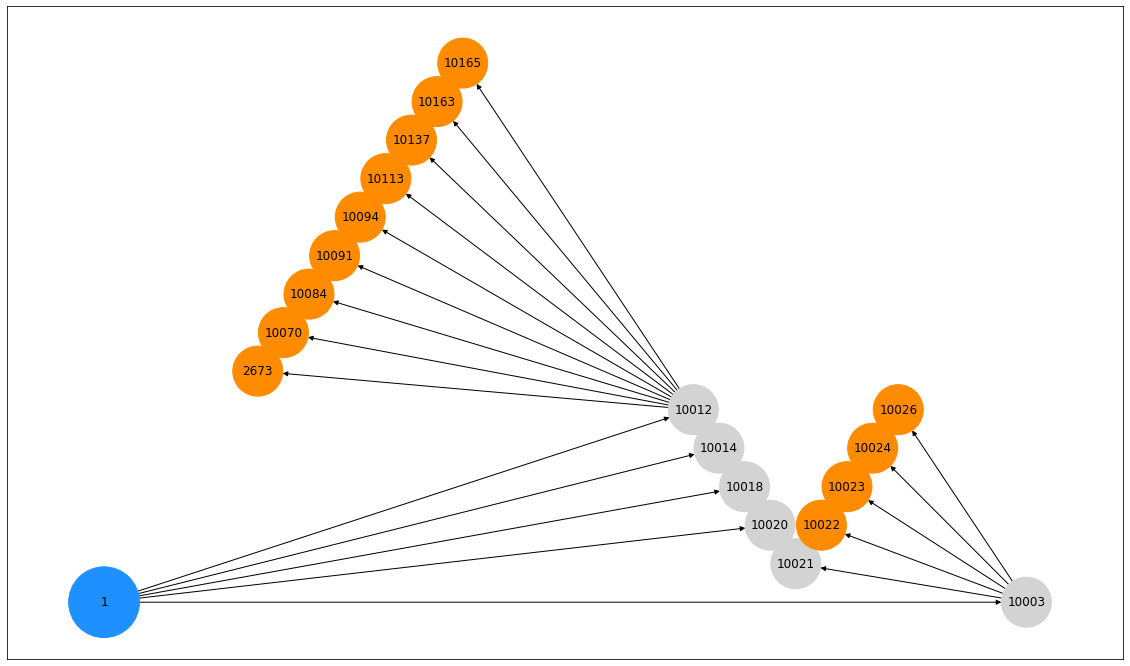

In [3]:
# граф категорий и родители каждой листовой категории
G = nx.read_gpickle("graph.gpickle")
hier.draw_top_graph(G, n=20)

Валидировать модели будем на отложенной выборке, так как на кросс-валидации долго.

In [4]:
y = X['category_id'].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X,y,
    stratify=y,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

X_train.shape, X_val.shape, y_train.shape

((226720, 11), (56680, 11), (226720,))

Посмотрим как внутри алгоритма будут распределяться образцы между базовыми классификаторами, для этого создадим пустой классификатор, который соберет инфу:

In [ ]:
hier_info = []

class DummyClassifier(BaseEstimator):
    def __init__(self, node_id):
        self.node_id = node_id
        self.classes_=0

    def fit(self, X, y):
        uniq_cats, counts = np.unique(y, return_counts=True)
        hier_info.append([self.node_id, X.shape[0], len(uniq_cats), uniq_cats])


def make_DummyClassifier(node_id, graph):
    return DummyClassifier(node_id)

hiclf = HiClassifier(base_estimator=make_DummyClassifier,
        class_hierarchy=G)
_ = hiclf.fit(X_train['id'], y_train)

В результате fit в графе категорий для данного X_train сохранились все локальные датасеты (разбиения) для каждого локального классификатора. Так как они считаются длительное время библиотекой и все находятся в памяти одновременно, то сохраним их в файл и далее мы можем эти разбиения использовать из файла указав параметр path_graph. Разбиения корректны только конкретной версии X_train, в данном случае она определяется RANDOM_STATE.

In [39]:
hiclf.save_graph(PATH_GRAPH)

Таблица ниже дает нам информацию о том, в каких узлах графа категорий будет наиболее сложная классификация, где больше образцов нужно классифицировать, где больше уникальных меток среди таргетов. Ниже в ноутбуке подберем соответствующие базовые модели для каждого узла, ориентируясь на это. Индекс в таблице соответствует в каком порядке будет вызываться классификатор.

In [38]:
hier_info = pd.DataFrame(hier_info, columns=['node_id','number_objects', 'number_uniq_categories', 'uniq_categories'])
hier_info.to_csv('hier_info.csv',index=False)
hier_info.sort_values('number_objects',ascending=False)[:15]

,node_id,number_objects,number_uniq_categories,uniq_categories
0,1,226719,5,"[10003, 10012, 10014,..."
149,10018,57677,9,"[2894, 10049, 10058, ..."
83,10014,44303,9,"[2807, 10034, 10052, ..."
1,10003,44228,5,"[10021, 10022, 10023,..."
45,10012,41458,12,"[2673, 10070, 10084, ..."
196,10020,39053,15,"[10030, 10044, 10073,..."
15,10023,30771,13,"[2606, 10045, 10060, ..."
199,10044,25556,5,"[10398, 11717, 12690,..."
200,10398,25302,14,"[11281, 11937, 12111,..."
107,10116,22921,14,"[10418, 10500, 10533,..."


В итоге будет тренироваться 240 базовых классификаторов, им достанется от 4 до 226514 обьектов, и от 2 до 22 категорий.

In [36]:
def mode(x): return pd.Series.mode(x)[0]

hier_info[['number_objects','number_uniq_categories']].agg(['min','max',mode])

,number_objects,number_uniq_categories
min,4,2
max,226719,22
mode,61,2


# Tfidf hF1=0.939
Посчитаем метрики на иерархическом классификаторе с базовыми моделями линейной регрессии на тренировочном датасете с фичей 'title_desc_chars' преобразованной в вектора с помощью Tfidf. Остальные фичи пока не рассматриваем. Определим функцию, которая будет делать Tfidf преобразование и удалять образцы из тренировочного набора, у которых получатся все признаки равны 0.

In [5]:
def non_null_rows(x):
    return np.diff(x.indptr) != 0

def tfidf_without_null_rows(tf, X_train, y_train):
    X_train_tf = tf.fit_transform(X_train)    
    ids = non_null_rows(X_train_tf)   
    return X_train_tf[ids], y_train[ids]

In [6]:
tf = TfidfVectorizer(min_df=10, lowercase=False)

X_train_tf, y_train_tf = tfidf_without_null_rows(tf, X_train['title_desc_chars'], y_train)
X_val_tf = tf.transform(X_val['title_desc_chars'])
X_train_tf.shape

(226649, 11163)

HiClassifier - иерархический классификатор вида local classifier per parent node. По умолчанию он в качестве local classifier выбирает LogisticRegression. HiClassifier ускоряет библиотечный HierarchicalClassifier и снижает его потребление памяти, добавляет функции сохранения и загрузки графа категорий с разбиениями. Находится в файле hier.py  

In [30]:
hiclf = HiClassifier(class_hierarchy=G)
hiclf.fit(X_train_tf,y_train_tf)
y_pred = hiclf.predict(X_val_tf)

hP, hR, hF1 = hier.h_scores(y_val, y_pred, G)

print(f"hP={hP} hR={hR} hF1={hF1} time_fit={hiclf.time_fit}min time_predict={hiclf.time_predict}min")

hP=0.935 hR=0.936 hF1=0.935 time_fit=21.5min time_predict=2.2min


Добавим Tfidf в bigrams - результат такой же если ограничить max_features:

In [11]:
tf = TfidfVectorizer(min_df=10, max_features=10000, ngram_range=(1,2), lowercase=False)

X_train_tf, y_train_tf = tfidf_without_null_rows(tf, X_train['title_desc_chars'], y_train)
X_val_tf = tf.transform(X_val['title_desc_chars'])

hiclf = HiClassifier(class_hierarchy=G)
hiclf.fit(X_train_tf,y_train_tf)
y_pred = hiclf.predict(X_val_tf)

hP, hR, hF1 = hier.h_scores(y_val, y_pred, G)

print(f"hP={hP} hR={hR} hF1={hF1} time_fit={hiclf.time_fit}min time_predict={hiclf.time_predict}min")

hP=0.934 hR=0.935 hF1=0.935 time_fit=19.9min time_predict=2.1min


# MultinomialNB в качестве локального классификатора - hF1 = 0.9

In [9]:
tf = TfidfVectorizer(min_df=5, max_features=15000, ngram_range=(1,2), lowercase=False)

X_train_tf, y_train_tf = tfidf_without_null_rows(tf, X_train['title_desc_chars'], y_train)
X_val_tf = tf.transform(X_val['title_desc_chars'])

hiclf = HiClassifier(class_hierarchy=G, base_estimator = MultinomialNB())
hiclf.fit(X_train_tf,y_train_tf)
y_pred = hiclf.predict(X_val_tf)

hP, hR, hF1 = hier.h_scores(y_val, y_pred, G)

hP=0.899 hR=0.901 hF1=0.9 time_fit=14.7min time_predict=2.4min


# HashingVectorizer - hF1 = 0.927

In [17]:
hv = HashingVectorizer(n_features=2**13, ngram_range=(1,2), lowercase=False)

X_train_hv = hv.fit_transform(X_train['title_desc_chars'])
X_val_hv = hv.transform(X_val['title_desc_chars'])

hiclf = HiClassifier(path_graph=PATH_GRAPH)
hiclf.fit(X_train_hv,y_train)
y_pred = hiclf.predict(X_val_hv)

hP, hR, hF1 = hier.h_scores(y_val, y_pred, G)

print(f"hP={hP} hR={hR} hF1={hF1} time_fit={hiclf.time_fit}min time_predict={hiclf.time_predict}min")

hP=0.926 hR=0.927 hF1=0.927 time_fit=5.4min time_predict=2.1min


Влияние столбцов description and characteristics:

In [14]:
results = []
columns = ['title','title_desc','title_desc_chars']

for col in columns:
    tf = TfidfVectorizer(min_df=10, lowercase=False)

    X_train_tf = tf.fit_transform(X_train[col])
    X_val_tf = tf.transform(X_val[col])
    
    hiclf = HiClassifier(class_hierarchy=G)
    hiclf.fit(X_train_tf,y_train_tf)
    y_pred = hiclf.predict(X_val_tf)

    hP, hR, hF1 = hier.h_scores(y_val, y_pred, G)

    results.append([col, hF1, hP, hR, hiclf.time_fit, hiclf.time_predict])

results = pd.DataFrame(results, columns=['column', 'hF1', 'hP', 'hR', 'time_fit','time_predict']).sort_values(by='hF1', ascending=False)
results

,title_desc_chars,hF1,hP,hR,time_fit,time_predict
2,title_desc_chars,0.935,0.935,0.936,18.700,1.400
1,title_desc,0.935,0.935,0.936,18.900,1.400
0,title,0.934,0.934,0.933,19.300,1.300


Посмотрим как влияют разные пороги отсева редких слов в TfidfVectorizer, видно, что для лог регрессии hF1 увеличивается с ростом количества задействованных слов, а время обучения растет несильно при этом, а время предикта значительно увеличивается:

In [8]:
results = []
thresholds = [5, 10, 20, 30]

for min_df in thresholds:
    tf = TfidfVectorizer(min_df=min_df, lowercase=False)

    X_train_tf, y_train_tf = tfidf_without_null_rows(tf, X_train['title_desc_chars'], y_train)
    X_val_tf = tf.transform(X_val['title_desc_chars'])
    
    hiclf = HiClassifier(class_hierarchy=G)
    hiclf.fit(X_train_tf,y_train_tf)
    y_pred = hiclf.predict(X_val_tf)

    hP, hR, hF1 = hier.h_scores(y_val, y_pred, G)   

    results.append([min_df, X_train_tf.shape[1], hF1, hP, hR, hiclf.time_fit, hiclf.time_predict])

results = pd.DataFrame(results, columns=['min_count_words','number_features', 'hF1', 'hP', 'hR', 'time_fit','time_predict']).sort_values(by='hF1', ascending=False)
results

,min_count_words,number_features,hF1,hP,hR,time_fit,time_predict
0,5,16834,0.936,0.936,0.936,22.500,2.400
1,10,11163,0.935,0.935,0.936,20.800,2.100
2,20,7426,0.934,0.934,0.935,19.800,1.900
3,30,5791,0.933,0.933,0.933,19.300,1.800


Влияние регуляризации:

In [11]:
results = []
Cs = np.logspace(-5, 2, base=10, num=10)

for C in Cs:
    lg = LogisticRegression(
        C=C, multi_class="multinomial", max_iter=1000, random_state=RANDOM_STATE
    )
    hiclf = HiClassifier(base_estimator =lg, path_graph = 'out/graph34tf')
    hiclf.fit(X_train_tf, y_train_tf)
    y_pred = hiclf.predict(X_val_tf)

    hP, hR, hF1 = hier.h_scores(y_val, y_pred, G)

    results.append([C, hF1, hP, hR, hiclf.time_fit, hiclf.time_predict])

results1 = pd.DataFrame(results, columns=['C', 'hF1', 'hP', 'hR', 'time_fit','time_predict']).sort_values(by='hF1', ascending=False)
results1

,C,hF1,hP,hR,time_fit,time_predict
7,2.783,0.939,0.939,0.939,7.000,1.500
8,16.681,0.939,0.939,0.939,11.300,1.600
9,100.000,0.934,0.934,0.934,18.400,1.500
6,0.464,0.930,0.929,0.931,4.400,1.600
5,0.077,0.900,0.898,0.902,3.100,1.600
4,0.013,0.823,0.818,0.829,2.500,1.700
3,0.002,0.713,0.708,0.717,2.500,1.800
2,0.000,0.570,0.562,0.577,3.300,1.600
1,0.000,0.471,0.456,0.486,5.100,1.500
0,0.000,0.470,0.456,0.486,7.900,1.500


# Doc2vec - hF1 = 0.878
Сравним результаты для векторных представлений doc2vec для разных vector_sizes = [200, 400, 600]

In [4]:
X_train_tagged = X_train.apply(
    lambda row: TaggedDocument(words=row['title_desc_chars'].split()[:50], tags=[row['id']]), axis=1)
X_val_tagged = X_val.apply(
    lambda row: TaggedDocument(words=row['title_desc_chars'].split()[:50], tags=[row['id']]), axis=1)
del X_train,X_val,X
gc.collect()
X_train_tagged[0]

TaggedDocument(words=['платье', 'golden', 'kids', 'art', 'девочка', 'платье', 'golden', 'kids', 'art', 'хит', 'сезон', 'незаменимый', 'вещь', 'гардероб', 'девочка', 'платье', 'служить', 'каждодневный', 'наряд', 'одежда', 'торжество', 'дополнительный', 'бонус', 'сочетаться', 'узкий', 'брюки', 'заузить', 'джинсы', 'размер'], tags=[580050])

In [5]:
def doc2vec(X_train_tagged, X_val_tagged, vector_size=200):
    model_dbow = Doc2Vec(
        dm=0,
        vector_size=vector_size,
        window=5,
        negative=3,
        hs=0,
        min_count=10,
        workers=4,
        epochs=30,
    )
    model_dbow.build_vocab(X_train_tagged)

    model_dbow.train(X_train_tagged, total_examples=len(X_train_tagged), epochs=30)
    
    X_doc_train = np.array([model_dbow.infer_vector(tag_doc.words) for tag_doc in tqdm(X_train_tagged)])
    X_doc_val = np.array([model_dbow.infer_vector(tag_doc.words) for tag_doc in tqdm(X_val_tagged)])
    return X_doc_train, X_doc_val

In [19]:
results = []
vector_sizes = [200, 400, 600]
hiclf = HiClassifier(path_graph=PATH_GRAPH)

for size in vector_sizes:
    
    X_doc_train, X_doc_val = doc2vec(X_train_tagged, X_val_tagged, vector_size=size)
    gc.collect()

    hiclf.fit(X_doc_train,y_train)
    y_pred = hiclf.predict(X_doc_val)
    hP, hR, hF1 = hier.h_scores(y_val, y_pred, G)

    results.append([size, hF1, hP, hR, hiclf.time_fit, hiclf.time_predict])
    
results = pd.DataFrame(results, columns=['vector_size','hF1', 'hP', 'hR', 'time_fit','time_predict']).sort_values(by='hF1', ascending=False)
results

,vector_size,hF1,hP,hR,time_fit,time_predict
1,600,0.878,0.878,0.878,9.700,1.800
2,400,0.876,0.876,0.877,7.500,1.800
0,200,0.871,0.870,0.871,4.400,0.900


# Pretrained sentence transformers - hF1 = 0.876

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v1',device='cuda')
model.max_seq_length = 50

In [ ]:
X_train_emb = model.encode(X_train['title_desc_chars'],device='cuda')
X_val_emb = model.encode(X_val['title_desc_chars'],device='cuda')

In [20]:
hiclf = HiClassifier(path_graph=PATH_GRAPH)

hiclf.fit(X_train_emb,y_train)
y_pred = hiclf.predict(X_val_emb)

hP, hR, hF1 = hier.h_scores(y_val, y_pred, G)

print(f"hP={hP} hR={hR} hF1={hF1}")

hP=0.875 hR=0.877 hF1=0.876
